In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from scipy import linalg, optimize, spatial
from hdlogistic import *

In [2]:
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

In [208]:
res = {}

In [467]:
def dataGenerator(n, p, dependence, sparsity, parameters):
    if dependence == 'iid':
        X = np.random.randn(n,p)
    elif dependence == 'eqcorr':
        eta = parameters['eta']
        X = np.random.randn(n,p)
        w = np.random.randn(n,1)
        X = X + (1-eta)*w
    elif dependence == 'eqcorr2':
        eta = parameters['eta']
        X = np.random.randn(n,p)
        X = X + (1-eta)*X[:,0:4].sum(axis=1,keepdims=True)
    
    beta_true = np.zeros((p,1))
    if sparsity == 'pol':
        b = parameters['b']
        r = parameters['r']
        beta_true = np.array([[b/((k+1)**(r)) for k in range(p)]]).T
    elif sparsity == 'exp':
        b = parameters['b']
        c = parameters['c']
        beta_true = np.array([[b/(c**(k+1)) for k in range(p) if k<50] + [0.0]*(p-50)]).T
    elif sparsity == 'str':
        beta = [parameters['beta'+str(s)] for s in range(parameters['s'])]
        beta_true = np.array([beta + [0]*(p-parameters['s'])]).T
        
    return np.float64(np.random.rand(n).reshape(n,1) < np.exp(X @ beta_true)/(1+np.exp(X @ beta_true))).ravel(), X, beta_true

# Model
$Y \sim logit( \sum_{i=1}^p \beta_i X_i)$

## CGA+HDAIC vs lasso

In [468]:
def simulation(n, n_test, p, m, dependence, sparsity, parameters):
#     print('*'+dependence+' '+sparsity)
    
    wn, C, cv = parameters['wn'], parameters['C'], parameters['cv']
    
    if sparsity == 'pol':
        print(' n:'+str(n), 'wn:'+str(wn), 'C:'+str(C), 'b:', parameters['b'], 'r:', parameters['r'])
    elif sparsity == 'exp':
        print(' n:'+str(n), 'wn:'+str(wn), 'C:'+str(C), 'b:', parameters['b'], 'c:', parameters['c'])
    elif sparsity == 'str':
        beta = [parameters['beta'+str(s)] for s in range(parameters['s'])]
        print(' n:'+str(n), 'beta:', beta)
    
    logLossCGA = np.zeros(m)
    logLossLasso = np.zeros(m)
    logLossLassoCV = np.zeros(m)
    
    logLossCGA = np.zeros(m)
    logLossLasso = np.zeros(m)
    logLossLassoCV = np.zeros(m)
    
    for t in range(m):
        y, X, beta_true =  dataGenerator(n, p, dependence, sparsity, parameters)
        y_test, X_test, _ =  dataGenerator(n_test, p, dependence, sparsity, parameters)

        # CGA
        hdLogisticReg = HighDimensionalLogisticRegression(trimming=False, fit_intercept=False, ic='AIC', wn = wn, kn=4, method='Newton-CG').fit(X,y)
        y_hat = hdLogisticReg.predict_proba(X_test)
        logLossCGA[t] = log_loss(y_test, y_hat)

        #lasso 0.5
        clf_l1 = LogisticRegression(C=C, penalty='l1', solver='liblinear', fit_intercept=False).fit(X, y)
        y_hat = clf_l1.predict_proba(X_test)
        logLossLasso[t] = log_loss(y_test, y_hat)

        #lasso 10CV
        clfL1CV = LogisticRegressionCV(cv=cv, penalty='l1', solver='liblinear', fit_intercept=False).fit(X, y)
        y_hat = clfL1CV.predict_proba(X_test)
        logLossLassoCV[t] = log_loss(y_test, y_hat)
    
    print(' logLossCGA: {:.4f}, std: {:.4f}'.format(logLossCGA.mean(), logLossCGA.std()))
    print(' logLossLasso: {:.4f}, std: {:.4f}'.format(logLossLasso.mean(), logLossLasso.std()))
    print(' logLossLassoCV: {:.4f}, std: {:.4f}'.format(logLossLassoCV.mean(), logLossLassoCV.std()))
    
    return logLossCGA.mean(), logLossLasso.mean(), logLossLassoCV.mean(), logLossCGA.std(), logLossLasso.std(), logLossLassoCV.std()

In [225]:
# res[(dependence, sparsity, n, n_test, m, *list(parameters.values()))]
dependence = ['iid']
sparsity = ['pol', 'exp', 'str']
ns = [200, 400, 600, 800]
n_test = 300
m = 300
# beta = [3, 4, 3, 5]
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
for d in dependence:
    for s in sparsity:
        print('*'+d+' '+s+' '+'------------------------')
        for n in ns:
            res[(d, s, n, n_test, m, *list(parameters.values()))] = simulation(n, n_test, 5*n, m, d, s, parameters)
        print('---------------------------------')

*iid pol ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.3138, std: 0.0503
 logLossLasso: 0.3451, std: 0.0417
 logLossLassoCV: 0.3933, std: 0.0625
 n:400 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2817, std: 0.0322
 logLossLasso: 0.3329, std: 0.0415
 logLossLassoCV: 0.3382, std: 0.0385
 n:600 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2727, std: 0.0333
 logLossLasso: 0.3348, std: 0.0437
 logLossLassoCV: 0.3064, std: 0.0273
 n:800 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2621, std: 0.0328
 logLossLasso: 0.3329, std: 0.0466
 logLossLassoCV: 0.2874, std: 0.0241
---------------------------------
*iid exp ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.4286, std: 0.0516
 logLossLasso: 0.5233, std: 0.0580
 logLossLassoCV: 0.5160, std: 0.0833
 n:400 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3993, std: 0.0344
 logLossLasso: 0.5392, std: 0.0594
 logLossLassoCV: 0.4371, std: 0.0454
 n:600 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3958, std: 0.03

In [243]:
# res[dependence, sparsity, n, n_test, m, parameters.values()]
dependence = ['eqcorr','eqcorr2']
sparsity = ['pol', 'exp', 'str']
ns = [200, 400, 600, 800]
n_test = 300
m = 300
# beta = [3, 4, 3, 5]
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
for d in dependence:
    for s in sparsity:
        print('*'+d+' '+s+' '+'------------------------')
        for n in ns:
            res[(d, s, n, n_test, m, *list(parameters.values()))] = simulation(n, n_test, 5*n, m, d, s, parameters)
        print('---------------------------------')

*eqcorr pol ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.3243, std: 0.2107
 logLossLasso: 0.1982, std: 0.0330
 logLossLassoCV: 0.2526, std: 0.0676
 n:400 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2526, std: 0.1413
 logLossLasso: 0.1787, std: 0.0340
 logLossLassoCV: 0.2198, std: 0.0376
 n:600 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2183, std: 0.0418
 logLossLasso: 0.1753, std: 0.0316
 logLossLassoCV: 0.1932, std: 0.0269
 n:800 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2020, std: 0.0400
 logLossLasso: 0.1728, std: 0.0328
 logLossLassoCV: 0.1811, std: 0.0199
---------------------------------
*eqcorr exp ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3173, std: 0.0593
 logLossLasso: 0.3512, std: 0.0513
 logLossLassoCV: 0.3746, std: 0.0529
 n:400 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.2846, std: 0.0364
 logLossLasso: 0.3513, std: 0.0478
 logLossLassoCV: 0.3171, std: 0.0348
 n:600 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.2687, std

In [471]:
# res[dependence, sparsity, n, n_test, m, parameters.values()]
dependence = ['eqcorr']
sparsity = ['pol', 'exp', 'str']
ns = [200, 400, 600, 800]
n_test = 300
m = 300
# beta = [3, 4, 3, 5]
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.8, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
for d in dependence:
    for s in sparsity:
        print('*'+d+' '+s+' '+'------------------------')
        for n in ns:
            res[(d, s, n, n_test, m, *list(parameters.values()))] = simulation(n, n_test, 5*n, m, d, s, parameters)
        print('---------------------------------')

*eqcorr pol ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.3210, std: 0.0547
 logLossLasso: 0.3257, std: 0.0402
 logLossLassoCV: 0.3736, std: 0.0784
 n:400 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2831, std: 0.0355
 logLossLasso: 0.3077, std: 0.0415
 logLossLassoCV: 0.3259, std: 0.0449
 n:600 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2703, std: 0.0342
 logLossLasso: 0.3076, std: 0.0428
 logLossLassoCV: 0.2989, std: 0.0281
 n:800 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2609, std: 0.0342
 logLossLasso: 0.3073, std: 0.0472
 logLossLassoCV: 0.2781, std: 0.0242
---------------------------------
*eqcorr exp ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.4176, std: 0.0473
 logLossLasso: 0.5063, std: 0.0569
 logLossLassoCV: 0.5050, std: 0.0860
 n:400 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3859, std: 0.0331
 logLossLasso: 0.5197, std: 0.0634
 logLossLassoCV: 0.4221, std: 0.0446
 n:600 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3811, std

In [472]:
# res[dependence, sparsity, n, n_test, m, parameters.values()]
dependence = ['eqcorr2']
sparsity = ['pol', 'exp', 'str']
ns = [200, 400, 600, 800]
n_test = 300
m = 300
# beta = [3, 4, 3, 5]
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.9, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
for d in dependence:
    for s in sparsity:
        print('*'+d+' '+s+' '+'------------------------')
        for n in ns:
            res[(d, s, n, n_test, m, *list(parameters.values()))] = simulation(n, n_test, 5*n, m, d, s, parameters)
        print('---------------------------------')

*eqcorr2 pol ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2581, std: 0.0425
 logLossLasso: 0.2666, std: 0.0337
 logLossLassoCV: 0.3260, std: 0.0670
 n:400 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.2214, std: 0.0382
 logLossLasso: 0.2506, std: 0.0370
 logLossLassoCV: 0.2782, std: 0.0292
 n:600 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.1975, std: 0.0317
 logLossLasso: 0.2425, std: 0.0394
 logLossLassoCV: 0.2461, std: 0.0208
 n:800 wn:2.0 C:0.5 b: 5.0 r: 1.5
 logLossCGA: 0.1923, std: 0.0300
 logLossLasso: 0.2395, std: 0.0378
 logLossLassoCV: 0.2291, std: 0.0185
---------------------------------
*eqcorr2 exp ------------------------
 n:200 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3641, std: 0.0481
 logLossLasso: 0.4276, std: 0.0480
 logLossLassoCV: 0.4630, std: 0.1228
 n:400 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3374, std: 0.0341
 logLossLasso: 0.4362, std: 0.0546
 logLossLassoCV: 0.3781, std: 0.0656
 n:600 wn:2.0 C:0.5 b: 5.0 c: 2.0
 logLossCGA: 0.3265, s

## IID

In [568]:
data={}

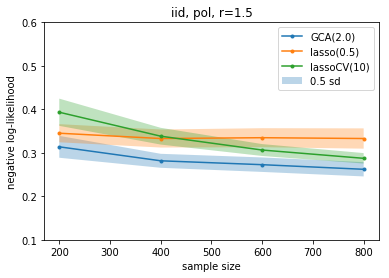

In [569]:
dependence = ['iid']
sparsity = ['pol']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))
sd_GCA = np.zeros(len(ns))
sd_lasso = np.zeros(len(ns))
sd_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
            sd_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][3]
            sd_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][4]
            sd_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][5]
        plt.plot(ns, res_GCA, '.-', label=labelCGA)
        plt.plot(ns, res_lasso, '.-', label=labelLasso)
        plt.plot(ns, res_lassoCV, '.-', label=labelLassoCV)
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title(d+', '+s+', r='+str(parameters['r']))
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-r-'+str(parameters['r']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [570]:
sd_GCA

array([0.0502724 , 0.03219113, 0.03329532, 0.03280361])

In [571]:
data[d] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['r='+str(parameters['r'])] = [labelLassoCV,*res_lassoCV]

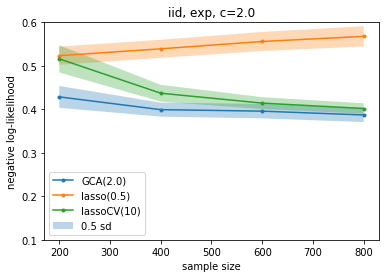

In [572]:
dependence = ['iid']
sparsity = ['exp']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title(d+', '+s+', c='+str(parameters['c']))
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-c-'+str(parameters['c']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [573]:
data[d+' '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['c='+str(parameters['c'])] = [labelLassoCV,*res_lassoCV]

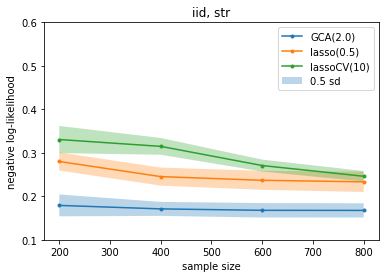

In [574]:
dependence = ['iid']
sparsity = ['str']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.2, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))


labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title(d+', '+s)
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'.png', bbox_inches='tight')
plt.show()

In [575]:
data[d+'  '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data[' '] = [labelLassoCV,*res_lassoCV]

In [576]:
df = pd.DataFrame(data, index=['sample size', 200, 400, 600, 800], dtype=float)

In [577]:
df.T.iloc[:,1:] = df.T.iloc[:,1:].replace('\$\s+','', regex=True).astype(float).applymap('{:,.3f}'.format)
print(df.T)
print('\n')
print(df.T.to_latex())

       sample size    200    400    600    800
iid       GCA(2.0)  0.314  0.282  0.273  0.262
pol     lasso(0.5)  0.345  0.333  0.335  0.333
r=1.5  lassoCV(10)  0.393  0.338  0.306  0.287
iid       GCA(2.0)  0.429  0.399  0.396  0.387
exp     lasso(0.5)  0.523  0.539  0.556  0.568
c=2.0  lassoCV(10)  0.516  0.437  0.414  0.402
iid       GCA(2.0)  0.179  0.171  0.168  0.168
str     lasso(0.5)  0.280  0.245  0.237  0.233
       lassoCV(10)  0.331  0.315  0.271  0.246


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
iid   &     GCA(2.0) &  0.314 &  0.282 &  0.273 &  0.262 \\
pol   &   lasso(0.5) &  0.345 &  0.333 &  0.335 &  0.333 \\
r=1.5 &  lassoCV(10) &  0.393 &  0.338 &  0.306 &  0.287 \\
iid   &     GCA(2.0) &  0.429 &  0.399 &  0.396 &  0.387 \\
exp   &   lasso(0.5) &  0.523 &  0.539 &  0.556 &  0.568 \\
c=2.0 &  lassoCV(10) &  0.516 &  0.437 &  0.414 &  0.402 \\
iid   &     GCA(2.0) &  0.179 &  0.171 &  0.168 &  0.168 \\
str   &  

## EQUAL CORRELATION

In [578]:
data={}

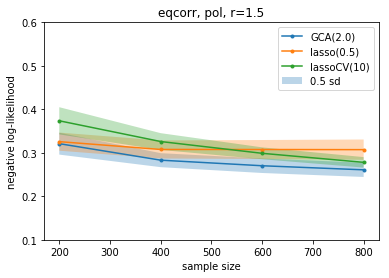

In [579]:
dependence = ['eqcorr']
sparsity = ['pol']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.8, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label=labelCGA)
        plt.plot(ns, res_lasso, '.-', label=labelLasso)
        plt.plot(ns, res_lassoCV, '.-', label=labelLassoCV)
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title(d+', '+s+', r='+str(parameters['r']))
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-r-'+str(parameters['r']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [580]:
data[d] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['r='+str(parameters['r'])] = [labelLassoCV,*res_lassoCV]

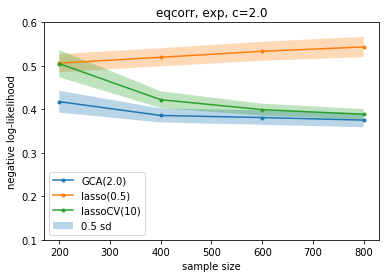

In [581]:
sparsity = ['exp']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.8, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title( d+', '+s+', c='+str(parameters['c']))
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-c-'+str(parameters['c']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [582]:
data[d+' '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['c='+str(parameters['c'])] = [labelLassoCV,*res_lassoCV]

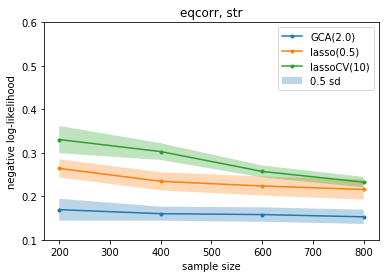

In [583]:
sparsity = ['str']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.8, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))


labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
title = d+', '+s
plt.title(title)
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'.png', bbox_inches='tight')
plt.show()

In [584]:
data[d+'  '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data[' '] = [labelLassoCV,*res_lassoCV]

In [585]:
df = pd.DataFrame(data, index=['sample size', 200, 400, 600, 800], dtype=float)

In [586]:
df.T.iloc[:,1:] = df.T.iloc[:,1:].replace('\$\s+','', regex=True).astype(float).applymap('{:,.3f}'.format)
print(df.T)
print('\n')
print(df.T.to_latex())

          sample size    200    400    600    800
eqcorr       GCA(2.0)  0.321  0.283  0.270  0.261
pol        lasso(0.5)  0.326  0.308  0.308  0.307
r=1.5     lassoCV(10)  0.374  0.326  0.299  0.278
eqcorr       GCA(2.0)  0.418  0.386  0.381  0.375
exp        lasso(0.5)  0.506  0.520  0.533  0.543
c=2.0     lassoCV(10)  0.505  0.422  0.399  0.388
eqcorr       GCA(2.0)  0.169  0.160  0.158  0.153
str        lasso(0.5)  0.264  0.234  0.224  0.216
          lassoCV(10)  0.331  0.303  0.257  0.232


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
eqcorr   &     GCA(2.0) &  0.321 &  0.283 &  0.270 &  0.261 \\
pol      &   lasso(0.5) &  0.326 &  0.308 &  0.308 &  0.307 \\
r=1.5    &  lassoCV(10) &  0.374 &  0.326 &  0.299 &  0.278 \\
eqcorr   &     GCA(2.0) &  0.418 &  0.386 &  0.381 &  0.375 \\
exp      &   lasso(0.5) &  0.506 &  0.520 &  0.533 &  0.543 \\
c=2.0    &  lassoCV(10) &  0.505 &  0.422 &  0.399 &  0.388 \\
eqcorr   &     GCA(2.

## EQUAL CORRELATION 2

In [587]:
data={}

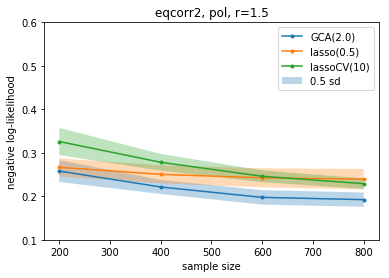

In [588]:
dependence = ['eqcorr2']
sparsity = ['pol']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.9, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label=labelCGA)
        plt.plot(ns, res_lasso, '.-', label=labelLasso)
        plt.plot(ns, res_lassoCV, '.-', label=labelLassoCV)
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
plt.title(d+', '+s+', r='+str(parameters['r']))
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-r-'+str(parameters['r']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [589]:
data[d] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['r='+str(parameters['r'])] = [labelLassoCV,*res_lassoCV]

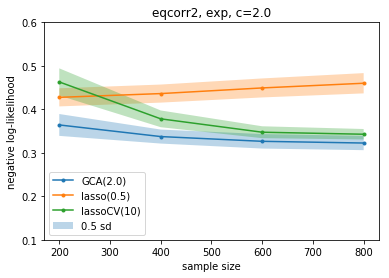

In [590]:
sparsity = ['exp']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.9, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))

labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
title = d+', '+s+', c='+str(parameters['c'])
plt.title(title)
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'-c-'+str(parameters['c']).replace(".", "")+'.png', bbox_inches='tight')
plt.show()

In [591]:
data[d+' '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data['c='+str(parameters['c'])] = [labelLassoCV,*res_lassoCV]

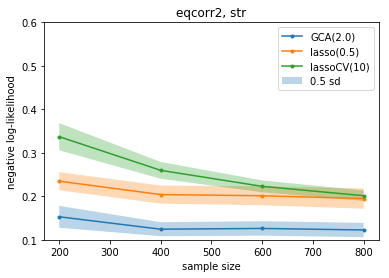

In [592]:
sparsity = ['str']
parameters = {'wn':2.0, 'C':0.5, 'cv':10 , 'b':5.0, 'r':1.5, 'c':2.0, 'eta':0.9, 
              's':4, 'beta0':3, 'beta1':4, 'beta2':3, 'beta3':5}
ns = [200, 400, 600, 800]
n_test = 300
m = 300

res_GCA = np.zeros(len(ns))
res_lasso = np.zeros(len(ns))
res_lassoCV = np.zeros(len(ns))


labelCGA = 'GCA('+str(parameters['wn'])+')'
labelLasso = 'lasso('+str(parameters['C'])+')'
labelLassoCV = 'lassoCV('+str(parameters['cv'])+')'

for d in dependence:
    for s in sparsity:
        for i,n in enumerate(ns):
            res_GCA[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][0]
            res_lasso[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][1]
            res_lassoCV[i] = res[(d, s, n, n_test, m, *list(parameters.values()))][2]
        plt.plot(ns, res_GCA, '.-', label='GCA('+str(parameters['wn'])+')')
        plt.plot(ns, res_lasso, '.-', label='lasso('+str(parameters['C'])+')')
        plt.plot(ns, res_lassoCV, '.-', label='lassoCV('+str(parameters['cv'])+')')
        plt.fill_between(ns, res_GCA-sd_GCA/2, res_GCA+sd_GCA/2, alpha = 0.3, label = '0.5 sd')
        plt.fill_between(ns, res_lasso-sd_lasso/2, res_lasso+sd_lasso/2, alpha = 0.3)
        plt.fill_between(ns, res_lassoCV-sd_lassoCV/2, res_lassoCV+sd_lassoCV/2, alpha = 0.3)
plt.ylim(0.1, 0.6)
title = d+', '+s
plt.title(title)
plt.xlabel('sample size')
plt.ylabel('negative log-likelihood')
plt.legend()
plt.savefig(d+'-'+s+'.png', bbox_inches='tight')
plt.show()

In [593]:
data[d+'  '] = [labelCGA,*res_GCA]
data[s]= [labelLasso,*res_lasso]
data[' '] = [labelLassoCV,*res_lassoCV]

In [594]:
df = pd.DataFrame(data, index=['sample size', 200, 400, 600, 800], dtype=float)

In [595]:
df.T.iloc[:,1:] = df.T.iloc[:,1:].replace('\$\s+','', regex=True).astype(float).applymap('{:,.3f}'.format)
print(df.T)
print('\n')
print(df.T.to_latex())

           sample size    200    400    600    800
eqcorr2       GCA(2.0)  0.258  0.221  0.198  0.192
pol         lasso(0.5)  0.267  0.251  0.242  0.240
r=1.5      lassoCV(10)  0.326  0.278  0.246  0.229
eqcorr2       GCA(2.0)  0.364  0.337  0.326  0.323
exp         lasso(0.5)  0.428  0.436  0.449  0.460
c=2.0      lassoCV(10)  0.463  0.378  0.347  0.343
eqcorr2       GCA(2.0)  0.153  0.124  0.126  0.123
str         lasso(0.5)  0.235  0.204  0.201  0.195
           lassoCV(10)  0.337  0.260  0.223  0.201


\begin{tabular}{llllll}
\toprule
{} &  sample size &    200 &    400 &    600 &    800 \\
\midrule
eqcorr2   &     GCA(2.0) &  0.258 &  0.221 &  0.198 &  0.192 \\
pol       &   lasso(0.5) &  0.267 &  0.251 &  0.242 &  0.240 \\
r=1.5     &  lassoCV(10) &  0.326 &  0.278 &  0.246 &  0.229 \\
eqcorr2   &     GCA(2.0) &  0.364 &  0.337 &  0.326 &  0.323 \\
exp       &   lasso(0.5) &  0.428 &  0.436 &  0.449 &  0.460 \\
c=2.0     &  lassoCV(10) &  0.463 &  0.378 &  0.347 &  0.343 \\
eqcor